# What Do You Value?
## Results, Good Decisions, or ...
## Using the Data To Drive Good Results and Decisions?

This is in reference to Greg's article here
https://employeecommunity.allstate.com/community/QR_and_A_Live/_layouts/ng/ActivityStream.aspx/id/DF3FD6EFFF2F28765308C25991948C4E/Activity+Stream+Post?/Lists/PublishedFeed

The point of Greg's article is that, despite winning $10,000, Timmy was a lucky idiot.  But I argue that this is only true if you know the rules of the game in advance.  Rarely is the real world so clean.

Bayesian analysis is a way to model uncertaintity about the real world, and, in some way of thinking, discover the rules of the game.

Let's take his example from the article.  We'll model the probability that you get a "1" in the game described with the random variable "p".  For sake of convienence we'll say $p$ is Beta distributed with parameters $\alpha = x$ and $\beta = 9x$ for some positive $x$.   $x$ here will represent how certain we are that we understand the underlying process.  A small $x$ means we aren't very confident, while a large $x$ means we are very confident.   Greg's analysis is analgous to $x$ tending towards infinity.

From the properties of the Beta distribution,

$$
\textrm{E}[p] = \frac{x}{x + 9x} = \frac{1}{10}
$$

Consider Timmy's 10 bets.   His successes are an additional r.v. $S$ which is

$$
S \sim \textrm{Binomial}\left( N=10, p \right)
$$

We seek to answer the question--how likely is it that we had the "right" value for $p$ given that we observed $S = 10$?  We are able to use Bayes law to capture the distribution of $p$ given our prior belief *and* the new observed data.   It turns out that there is actually a closed form to this question:

$$
p | S=s \sim \textrm{Beta}\left(\alpha' = x + s, \beta' = 9x + 10 - s\right)
$$

This magic happens because the Beta is a conjugate prior of the Binomial.    Given the distribution of $p | S$ we can find its expectation

$$
\textrm{E}[p | S = s] = \frac{x + s}{10x + 10}.
$$

In Spike's case $s = 10$--so how big does $x$ have to be to make Spike's bet the right bet?

$$
0.5 = \frac{x + 10}{10x + 10} \rightarrow x = 1.25
$$

For $x = 1.25$, $p$ was originally distrubted as

$$
p \sim \textrm{Beta}(\alpha = 1.25, \beta = 11.25)
$$

which has mean 1/10 and a standard deviation of 0.08165.     That is roughly analgous to a 95% confidence interval of (0, 0.26) on p.  In other words, Spike had to be more certain that $p$ was within (0, 0.26) in order for his bet to make sense.

This analysis was obviously simplified.  For starters, it's easy to say at the end of 10 bets what the course correction should have been.  It's much harder to do that in the middle of the game!   For instance, if we repeated the above analysis for only five games, our prior distribution would have to be much larger for us to change strategies.

Another simplication we made was the arbitrary choice of the Beta distribution.  Below we demonstrate that, though the choice of distribution was arbitrary, the results seem to hold pretty well for any prior distribution used.  There is no analytic form available for most of these choices, but we can use simulation to get a numerical approximation.

## Derivation of Posterior Distribution

The prior belief of $p$ was that it was Beta with parameters $\alpha = x$ and $\beta=9x$.  This has pdf

$$
f(p; \alpha, \beta) = \frac{p^{\alpha} (1 - p)^{\beta - 1}}{B(\alpha, \beta)}
$$

where $B(\alpha, \beta)$ is the beta function.  Note that the support is $0 \le p \le 1$.    Now the pdf for the number of successs is $S \sim \textrm{Binomial}\left(n, p\right)$ which has pdf:

$$
\Pr\{S = s\} = {{n} \choose {s}} p^{s} (1 - p)^{n-s}
$$

In the problem, we observe $s$ and seek to find the value of $\Pr{P = p | S = s}$.  Using Bayes theorem:

$$
\begin{eqnarray}
\Pr\{P = p | S = s\} & = & \frac{\Pr\{S = s | P = p\} \Pr\{P = p\}}{\Pr\{S = s\}} \\
 & = & K {{n} \choose {s}} p^{s} (1 - p)^{n-s} f(p; \alpha, \beta) \\
 & = & K' p^{s} (1 - p)^{n-s} f(p; \alpha, \beta) \\
 & = & K' p^{s} (1 - p)^{n-s} \frac{p^{\alpha} (1 - p)^{\beta - 1}}{B(\alpha, \beta)} \\
 & = & K'' p^{s + \alpha} (1-p)^{n - s + \beta - 1}
\end{eqnarray}
$$

which we recognizes as the pdf for a beta distribution with parameters $\alpha' = s + \alpha$ and $\beta' = \beta + n - s$ as claimed.

## Simulation Code

Our choice of prior was choosen in part because there was a clean analytic solution.   Python has a great package called PyMC that can help simulate scenarios for more complex situations.   Check out the excellent book https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers for more information.    R also has some great libraries to facilitate this type of thing.

First, import the libraries and setup graphics.

In [37]:
import pymc as pm
import numpy as np
from pymc.Matplot import plot
%matplotlib inline

Next, describe your random process.  (Again--read that book above--you can do much more complicated things!).  Here we are matching the problem formulation exactly as above.

In [32]:
x = 1.25
p_one = pm.Beta('p_one', alpha=x, beta=9*x)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)

We describe our model, which is just a collection of all the random variables.  And finally we run a procedure called MCMC (Monte Carlo Markov Chain), which approximates the problem we solved in the "Derivation" section.    Fully explaining how this works takes a textbook--here the only thing to note is that we're running 20,000 simulations and throwing out the first 5,000.  This is generally done to let the simulation "cool down" before you use its results.

In [33]:
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.0 sec

Next we're going to look at the results.  The top-left chart shows how the posterior distribution of p_one moves around over the simulation.  We expect to see no pattern here, so this is good.  The bottom left chart shows how correlated the values of p_one are for one simulation to the next.  Having a lot of autocorrelation is bad--here there does appear to be a minor issue with close simulations being too correlated.    We will rerun the simulation and  take , say, only every 20th run.

Plotting p_one


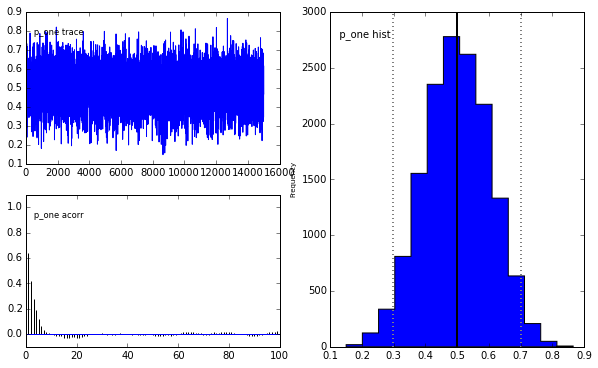

In [34]:
plot(mcmc)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 secPlotting p_one


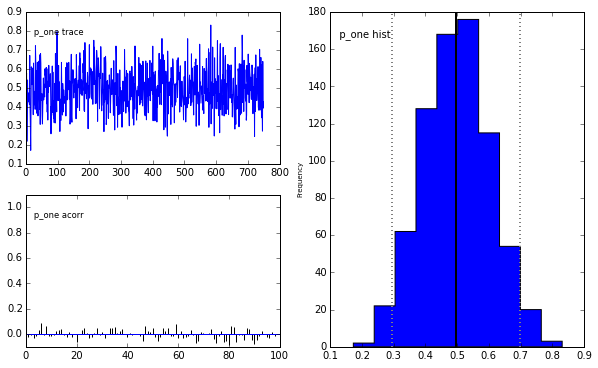

In [35]:
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)

In [38]:
np.mean( mcmc.trace('p_one')[:] )

0.49811035824615857

Much better. Finally the chart on the right shows the posterior distribution of p_one.  As you can see it is centered right around 0.50 which agrees with our assessment that x=1.25 was the break even point as above.  Below we'll try a few more values of $x$ so you can see the effect firsthand.

First we'll try to be REALLY certain about it.

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 secPlotting p_one


0.1823472680013872

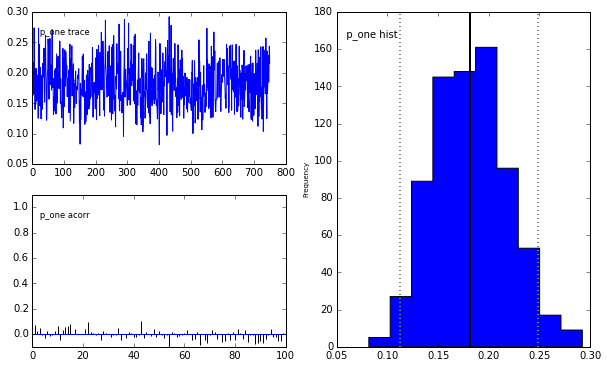

In [40]:
x = 10
p_one = pm.Beta('p_one', alpha=x, beta=9*x)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)
np.mean( mcmc.trace('p_one')[:] )

As you can see, the data wasn't enough to make us change our mind.   And here's us being really uncertain:

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 secPlotting p_one


0.92167164177778715

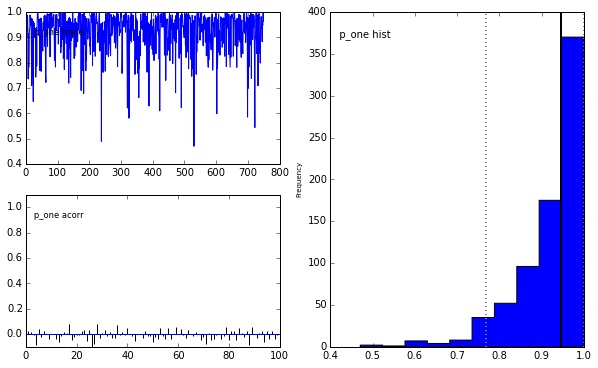

In [42]:
x = 0.1
p_one = pm.Beta('p_one', alpha=x, beta=9*x)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)
np.mean( mcmc.trace('p_one')[:] )

With little prior knowledge we completely change our tune!   Ok let's see what happens if we use a different prior other than beta.   The first example places a uniform prior over (0,1).  As you can see it's almost exactly the resutls we get back from the previous example.

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 secPlotting p_one


0.91694374421754099

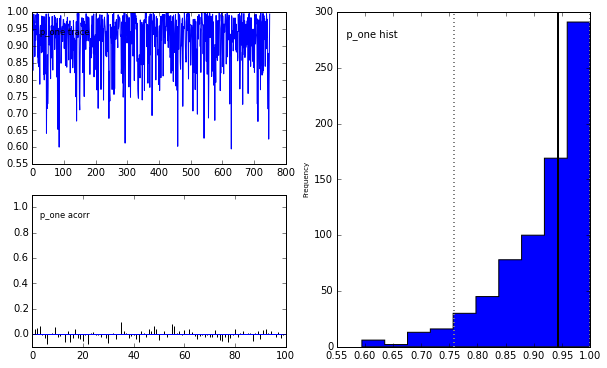

In [44]:
x = 0.1
p_one = pm.Uniform('p_one', lower=0, upper=1)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)
np.mean( mcmc.trace('p_one')[:] )

Here we'll try a uniform distribution on (0, 0.25)--but aha! It doesn't quite work out.  Because this distribution has no support outside of that range, the posterior can't either.

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 secPlotting p_one


0.22943355933182488

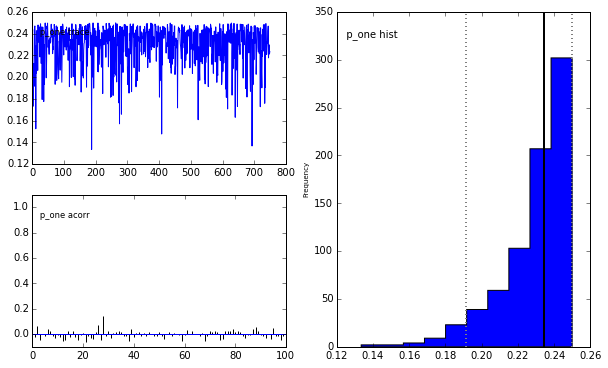

In [45]:
x = 0.1
p_one = pm.Uniform('p_one', lower=0, upper=0.25)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)
np.mean( mcmc.trace('p_one')[:] )

PyMC's normal distribution likes to use $tau = 1/sigma^2$--a value of 10 here is therefore a variance of 1/10.

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 secPlotting p_one


0.84383644238437183

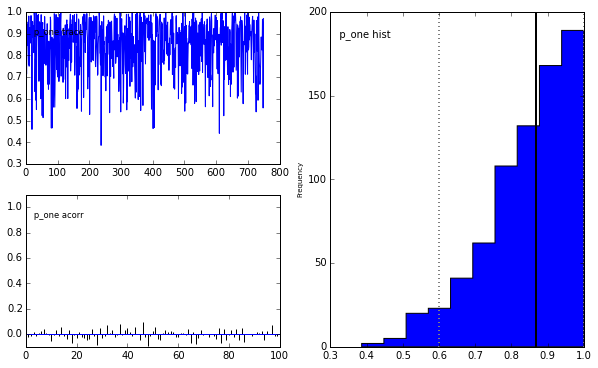

In [51]:
x = 0.1
p_one = pm.Normal('p_one', mu=0.10, tau=10)
timmy = pm.Binomial('timmy', p=p_one, n=10, value=10, observed=True)
model = [p_one, timmy]
mcmc = pm.MCMC(model)
mcmc.sample(20000,5000,20)
plot(mcmc)
np.mean( mcmc.trace('p_one')[:] )